# t-SNE visualization of CIFAR-100 models

In [1]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import umap
import torch

import sys, os
sys.path.append(os.getcwd())
sys.path.append('/home/vision/dongjun/mdistiller-private/')

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

/home/vision/anaconda3/envs/diverse_kd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:

from mdistiller.distillers import Vanilla
from mdistiller.models import  TeacherEnsemble
import torch.nn.functional as F

def randomize(x):
    x_noise = x.clone()
    noise = torch.randn_like(x_noise)
    x_noise = 0.9 * x_noise + 0.1 * noise
    return x_noise

# visualize t-SNE
def get_tsne(stu, mpath):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    all_features, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, features = model(data)
            all_features.append(features['pooled_feat'].data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    all_features = np.concatenate(all_features, 0)
    all_labels = np.concatenate(all_labels, 0)

    tsne = TSNE()
    all_features = tsne.fit_transform(all_features)
    plot_features(all_features, all_labels, num_classes)

def get_umap(stu, mpath, num_classes_to_show=5):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()

    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)

    state_dict = load_checkpoint(mpath)['model']
    tea_model = TeacherEnsemble(cfg, model, num_classes=100)
    
    #teacher 관련 파라미터만 추출 (prefix 제거)
    teacher_state_dict = {
        k.replace("module.teacher.", ""): v
        for k, v in state_dict.items()
        if k.startswith("module.teacher.")
    }
    #tea_model에 로드
    missing_keys, unexpected_keys = tea_model.load_state_dict(teacher_state_dict, strict=False)
    
    model = Vanilla(tea_model)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    all_logits, all_labels, all_sources = [], [], []
    
    with torch.no_grad():
        for idx, (image, labels) in enumerate(val_loader):
            image = image.float()
            image = image.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            
            # return_val = model.module.student(image)
            ensemble_output, view_logit_list, teacher_logit = model.module.student(image)
    
            for view_idx, logit in enumerate(view_logit_list):
                logit_with_noise = randomize(teacher_logit)
                logit = F.softmax(logit_with_noise, dim=1)
                
                #logit = F.softmax(logit, dim=1)
                all_logits.append(logit.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                all_sources.extend([f"view_{view_idx}"] * labels.shape[0])
            
            teacher_logit = F.softmax(teacher_logit, dim=1)
            all_logits.append(teacher_logit.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_sources.extend(["teacher"] * labels.shape[0])

    all_logits = np.concatenate(all_logits, axis=0)        # shape: [B * (5+1), C]
    all_labels = np.concatenate(all_labels, axis=0)        # shape: [B * (5+1)]
    all_sources = np.array(all_sources)                    # shape: [B * (5+1)]

    # 1️⃣ 클래스 필터링
    unique_classes = np.unique(all_labels)
    selected_classes = np.sort(unique_classes)[:num_classes_to_show]
    class_mask = np.isin(all_labels, selected_classes)

    logits_subset = all_logits[class_mask]
    labels_subset = all_labels[class_mask]
    sources_subset = all_sources[class_mask]

    # 2️⃣ 라벨 재매핑: 0 ~ num_classes_to_show-1
    class_id_map = {old: new for new, old in enumerate(selected_classes)}
    labels_subset = np.vectorize(class_id_map.get)(labels_subset)

    # 3️⃣ UMAP 수행
    reducer = umap.UMAP(n_neighbors=6,min_dist=0.1,n_components=2, random_state=42)
    umap_coords = reducer.fit_transform(logits_subset)

    # 4️⃣ 시각화
    plot_umap_by_source_and_class(umap_coords, labels_subset, sources_subset, num_classes_to_show)

def plot_umap_by_source_and_class(umap_coords, labels, sources, num_classes):
    colors = ['C' + str(i) for i in range(num_classes)]
    markers = {
        'teacher': 'x',
        'view_0': '.',
        'view_1': '.',
        'view_2': '.',
        'view_3': '.',
        'view_4': '.'
    }

    plt.figure(figsize=(8, 8))
    for class_id in range(num_classes):
        for source in np.unique(sources):
            mask = (labels == class_id) & (sources == source)
            if np.sum(mask) == 0:
                continue
            plt.scatter(
                umap_coords[mask, 0],
                umap_coords[mask, 1],
                c=colors[class_id],
                marker=markers[source],
                s=20 if source == 'teacher' else 8,
                alpha=0.6,
                label=f"class {class_id} - {source}"
            )

    # 범례: 중복 제거
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.legend(by_label.values(), by_label.keys(), fontsize=8, markerscale=1.5, loc='best')
    plt.xticks([])
    plt.yticks([])
    plt.title("UMAP of Teacher & Views / TeKAP")
    plt.tight_layout()
    plt.show()

def plot_features(features, labels, num_classes):
    colors = ['C' + str(i) for i in range(num_classes)]
    plt.figure(figsize=(6, 6))
    for l in range(num_classes):
        plt.scatter(
            features[labels == l, 0],
            features[labels == l, 1],
            c=colors[l], s=1, alpha=0.4, label=f"class {l}")
    plt.xticks([])
    plt.yticks([])
    plt.legend(markerscale=5, fontsize=8, loc='best')
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


/home/vision/anaconda3/envs/diverse_kd/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


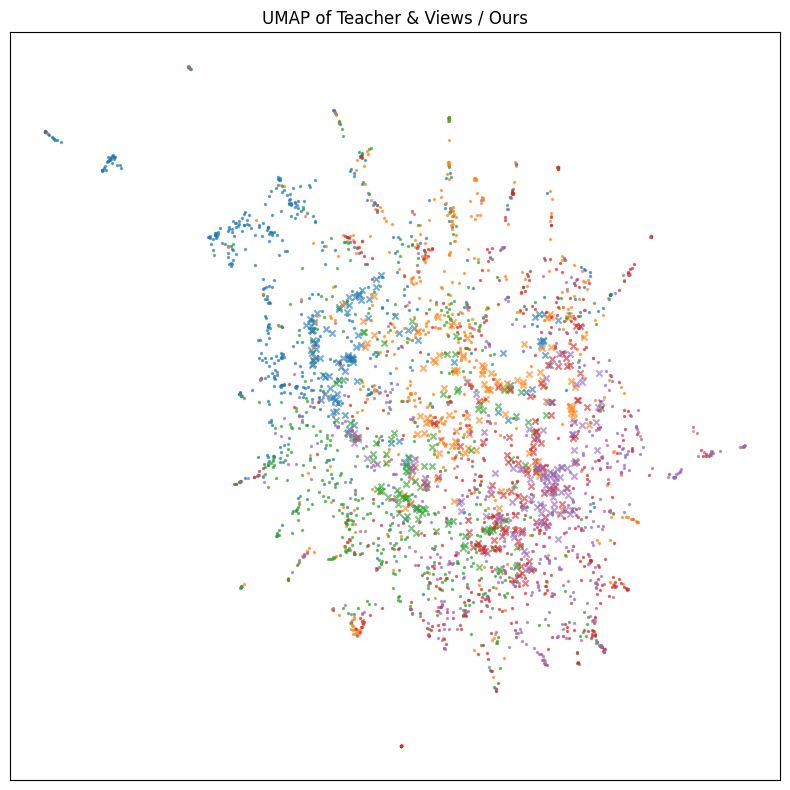

In [60]:
mpath = "../../output/cifar100_baselines/Rebuttal,Ours_N_5,res32x4,resnet8x4/best"
get_umap("resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified


/home/vision/anaconda3/envs/diverse_kd/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


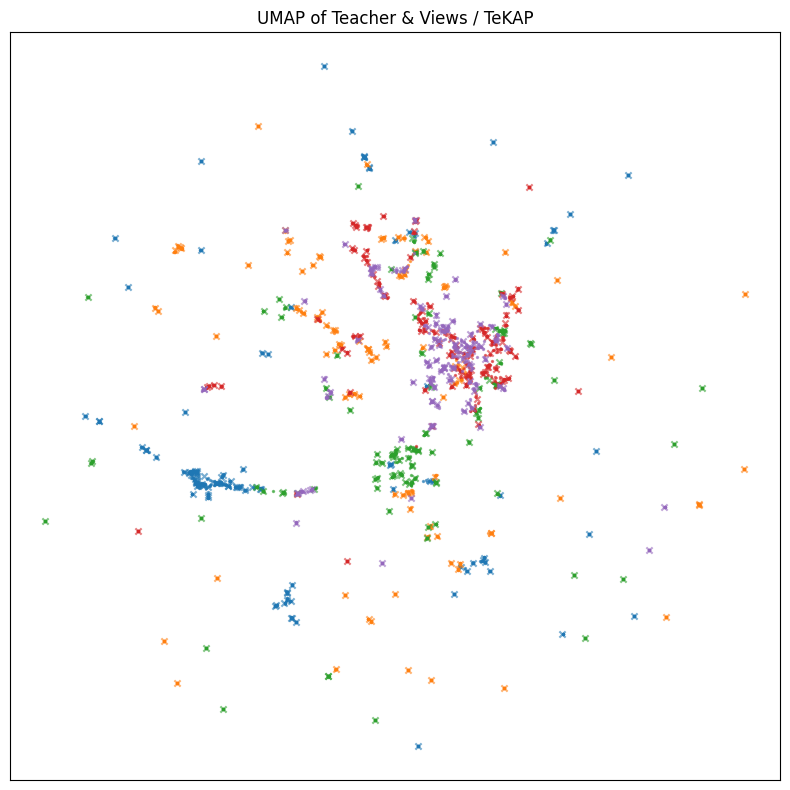

In [62]:
mpath = "../../output/cifar100_baselines/Rebuttal,Ours_N_5,res32x4,resnet8x4/best"
get_umap("resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified


157it [01:05,  2.40it/s]


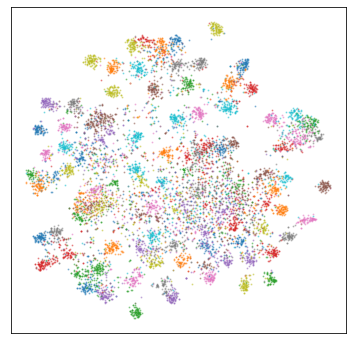

In [ ]:
# KD baseline
mpath = "../../download_ckpts/kd_resnet8x4"
get_tsne("resnet8x4", mpath)

Files already downloaded and verified
Files already downloaded and verified


157it [01:05,  2.40it/s]


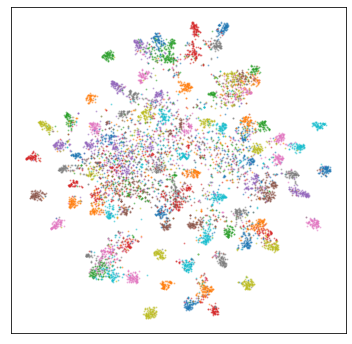

In [4]:
# Our DKD
mpath = "../../download_ckpts/dkd_resnet8x4"
get_tsne("resnet8x4", mpath)